Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Overview

This colab is supplemental code for the following publication:

Title: Recurrent Convolutional Deep Neural Networks for Modeling Time-resolved Wildfire Spread Behavior
Authors:  John Burge, Matthew R. Bonanni, R. Lily Hu, Matthias Ihme
Journal: Fire Technology, 2023

This colab will load in one of those models, and load in one file that contains data points for that model, and perform a single inference on one row of the data on the model.

The file containing the model (a .h5 file), and the file containing the data, must be uploaded to the colab server's local file system, and then when specifying the location of those files, use their location on the colab server.

This colab performs just a single inference, but it should be quite straightforward to modify it to perform more predictions.  Note that the paper details an 'autoregressive' process in which the result of a prediction made at time step t, is used in the input for time step t+1.  This colab only performs individual predictions, it does not replicate the (more complex) logic needed to perform predicitons across the entire autoregressive process.  See the paper for full details need to replicate that process (this colab should provide an adequate skeleton for how to perform the underlying predictions).

In [ ]:
#@title Imports.

!pip install ml-collections  # Install ml_collections for ConfigDict.

import os
from typing import Dict, Iterable, Tuple
from ml_collections import config_dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Functions supporting loading the data.

# Specifies the name of features added to tf.train.Example(s).
FEATURE_INPUT = 'input'
FEATURE_LABEL = 'label'


def get_tf_example_schema() -> Dict[str, tf.io.FixedLenFeature]:
  """Returns the example schema needed to load TFRecordDatasets."""
  return {
      FEATURE_INPUT: tf.io.FixedLenFeature([], dtype=tf.string),
      FEATURE_LABEL: tf.io.FixedLenFeature([], dtype=tf.string),
  }


def get_config():
  """Provides the config for this dataset."""
  cfg = config_dict.ConfigDict()

  # The base directory where all input files are located.  This must be
  # specified for the dataset to do anything meaningful.
  cfg.input_base = 'must specify'

  # To process more than one file, this is appended to the end of input base.
  cfg.glob = '*'

  # How many data points in a single batch.
  cfg.batch_size = 1

  return cfg


def _parse_example(data):
  result = tf.io.parse_single_example(
      data, get_tf_example_schema())
  feature_input = tf.io.parse_tensor(result[FEATURE_INPUT], tf.float64)
  feature_label = tf.io.parse_tensor(result[FEATURE_LABEL], tf.float64)
  return feature_input, feature_label


def create_dataset(cfg: config_dict.ConfigDict) -> tf.data.Dataset:
  """Returns the dataset specified in the config.

  Each element in the dataset is a tuple (A, B) where A is the input data and
  B is the label data.  A and B have the same shape.  If the data is temporal,
  the output shape is (b, t, h, w, c), otherwise it's (b, h, w, c).
  b = batch, t = time step, h,w = spatial dims, c=channels.
  """
  def _data_to_dict(
      input_data: tf.Tensor,
      label_data: tf.Tensor) -> Tuple[Dict[str, tf.Tensor], tf.Tensor]:
    return ({'input_image': input_data}, label_data)

  print('DATASET PROGRESS: Inside create.  Loading file: ', cfg.input_base)
  ds = tf.data.Dataset.list_files(cfg.input_base)
  ds = ds.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type='GZIP'),
      cycle_length=tf.data.experimental.AUTOTUNE,
      num_parallel_calls=tf.data.experimental.AUTOTUNE,
      deterministic=True)
  ds = ds.map(
      map_func=_parse_example,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.map(
      map_func=_data_to_dict, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.batch(cfg.batch_size, drop_remainder=True)
  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  return ds


In [ ]:
#@title Functions supporting load the model.


def _identity_activation(data: tf.Tensor) -> tf.Tensor:
  """A dummy activation that is the identity."""
  return data


class RemoveLastChannel(tf.keras.layers.Layer):
  """Removes the last channel of the input tensor."""

  def call(self, network):
    return network[..., :-1]


class LastChannelOneHot(tf.keras.layers.Layer):
  """Builds a one-hot encoding for the last channel of the input tensor.

  The last channel of the input tensor is assumed to be a channel with
  categorical values that range between 0 and some max value (though possible
  encoded as floats).
  """

  def __init__(self, num_values: int = 10, **kwargs):
    super(LastChannelOneHot, self).__init__(**kwargs)
    self.num_values = num_values

  def get_config(self):
    config = super(LastChannelOneHot, self).get_config()
    config.update({'num_values': self.num_values})
    return config

  def call(self, network):
    # Strip off just the last channel and cast to an integer value.
    network = network[..., -1]
    network = tf.cast(network, dtype=tf.int32)

    #  Transform that slice into a one-hot encoding.
    network = tf.one_hot(
        network,
        off_value=0.0,
        on_value=1.0,
        depth=self.num_values,
        dtype=tf.float32)

    return network


class ReshapeWithBatch(tf.keras.layers.Layer):
  """A Reshape layer that allows reshaping to effect the batch dimension.

  The stock tf.keras.layers.Reshape layer will not allow layers to be merged
  with the batch dimension.  E.g., assume the input to the layer had a shape
  (None, 3, 4) and the desired reshape was to get to was (None, 4).  I.e., the
  2nd dimension is being merged with the batch channel (which at graph-creation
  time, is unknown in size).  There's no way to accomplish this with a Layer
  like:

    tf.layers.Reshape(target_shape=(-1, 10)) will result

  That command would not change the size at all, as it would assume the -1 size
  was fine staying at '3'.  We want the -1 to indicate that the None and 2nd
  dimension are merged into a new, larger, batch dimension.  So, instead, use
  this layer like:

    tf.layers.ReshapeWithBatch(target_shape=(-1, 10))
  """

  def __init__(self, target_shape: Iterable[int], **kwargs):
    super(ReshapeWithBatch, self).__init__(**kwargs)
    self.target_shape = target_shape

  def get_config(self):
    config = super(ReshapeWithBatch, self).get_config()
    config.update({'target_shape': self.target_shape})
    return config

  def call(self, inputs):
    return tf.reshape(inputs, shape=self.target_shape)


Trying to list out the input_file:
/tmp/wildfire/real_nosun/nosun_test_static.tfr-00000-of-00153
Trying to list out the input_model:
/tmp/wildfire/real_wn/epd.h5
Using the folloing configuration for setting up the dataset:  batch_size: 1
glob: '*'
input_base: /tmp/wildfire/real_nosun/nosun_test_static.tfr-00000-of-00153

DATASET PROGRESS: Inside create.  Loading file:  /tmp/wildfire/real_nosun/nosun_test_static.tfr-00000-of-00153
Attempting to load the model from:  /tmp/wildfire/real_wn/epd.h5


Found row:  5
The input shape was:  (1, 126, 126, 17)
The label shape was:  (1, 126, 126, 1)
Performing an inference...
... done.  Prediction had the shape:  (1, 126, 126, 1)
The prediction shape was:  (1, 126, 126, 1)
The label shape was:  (1, 126, 126, 1)


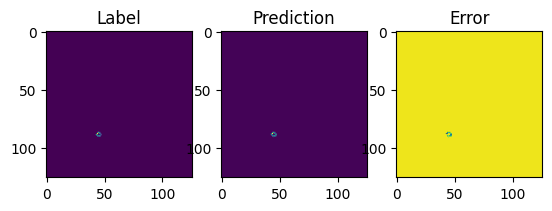

In [ ]:
#@title Performing the inference.

#
# Parameters
#

#@markdown **WARNING**: Be sure that if you specify a temporal model, you provide a temporal data file (likewise, a static model needs a static input file).

#@markdown Set this to the location of the input data file on the colab server (you must copy the file to the colab server first).
input_file = '/tmp/wildfire/real_nosun/nosun_test_static.tfr-00000-of-00153' #@param {type:'string'}

#@markdown Which row in the input file to get the data point from.  This will cause an error if there are not sufficient rows in the input data file.
input_row = 5 #@param {type: 'integer'}

# See if the input file exists.
print('Trying to list out the input_file:')
!ls $input_file

#@markdown Set the name of the file on the local colab server that contains the model to load.
input_model = '/tmp/wildfire/real_wn/epd.h5' #@param {type: 'string'}

# See if the input model exists.
print('Trying to list out the input_model:')
!ls $input_model

#
# Execute the inference.
#

# Set up the configuration for the dataset that will create data points.
cfg = get_config()
cfg.input_base = input_file
print('Using the folloing configuration for setting up the dataset: ', cfg)

# Get the dataset.
dataset = create_dataset(cfg=cfg)

# Need to load the model.
print('Attempting to load the model from: ', input_model)
model = tf.keras.models.load_model(
      input_model,
      custom_objects={'LastChannelOneHot': LastChannelOneHot,
                      'RemoveLastChannel': RemoveLastChannel,
                      'ReshapeWithBatch': ReshapeWithBatch,
                      '_identity_activation': _identity_activation})

# Iterate through the points in the dataset.
count = 0
for dp in dataset:
  count += 1
  if count == input_row:
    print('Found row: ', input_row)
    dp_input = dp[0]['input_image']
    dp_label = dp[1]
    print('The input shape was: ', dp_input.shape)
    print('The label shape was: ', dp_label.shape)

    print('Performing an inference...')
    pred = tf.cast(model(dp_input), tf.float64)
    print('... done.  Prediction had the shape: ', pred.shape)

    print('The prediction shape was: ', pred.shape)
    print('The label shape was: ', dp_label.shape)

    if len(pred.shape) == 5:
      # Temporal data, the final prediction is the last time step.
      pred = pred[0,-1,:,:,0]
      dp_label = dp_label[0,-1,:,:,0]
    elif len(pred.shape) == 4:
      # Static data, the final prediction is the final prediction.
      pred = pred[0,:,:,0]
      dp_label = dp_label[0,:,:,0]
    else:
      raise ValueError('The prediction has the wrong shape.')

    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(dp_label)
    axes[0].set_title('Label')
    axes[1].imshow(pred)
    axes[1].set_title('Prediction')
    error = dp_label - pred
    axes[2].imshow(error)
    axes[2].set_title('Error')

    # Only perform a single inference.
    break